#  Estimacion de ETA basado en redes neuronales LSTM
---
Las estimaciones de completitud tempral de ciertas tareas es un area de mucho interes de estudio debido a su potenciabilidad industrial en diversas areas.

En este trabajo se muestra un metodo para calcular el 'Tiempo estimado de arribo', por sus siglas en ingles "ETA", estudiando una muestra temprola del un movil en un circuito con registros de "GPS".
Para conseguir esto se diseno una red neuronal basada en el concepto de memoria a largo-corto plazo (por sus siglas en ingles LSTM).

se hazo un tratamiento muy simple a estos datos que estan en en un formato ".csv", se crearan variables apartir de los datos que ya tenemos, debido a la causalidad que se penso para ellos en cuanto al calculo.

Luego se hace un analisis de los datos y resultados frente al metodo presentado aqui.


## indice



1.   Estudiando el data set
2.   preparacion del data set, creacion de la red neuronal y entrenamiento 
3.   Analisis de resultados
4.   conclusion
---

# 1. estudiando el data set

En primer lugar se intentara omitir comentarios inecesarios como 'importacion de librerias' y otros redundates.
El analisis comienza observando la estructura del data set, donde podemos ver que el data set posee una estructura algo redundante para nuestro caso. Nuestro problema corresponde a la estimacion de ETA. por consiguiente observemos los datos veamos que cosas son las mas relevantes.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

asd = pd.read_csv('/home/cesar/JupyterNotebooks/LTSMeta/jesper-hageri.csv')
asd.head()

,Time,AltitudeMeters,LatitudeDegrees,LongitudeDegrees,HeartRateBpm,SecondsFromStart,DistanceTraveled
0,2020-05-07T10:18:05Z,49.0,59.217137,24.468916,NaN,0.0,0.000000
1,2020-05-07T10:18:41Z,48.0,59.216840,24.468779,NaN,36.0,111.149837
2,2020-05-07T10:19:11Z,47.0,59.211988,24.464601,NaN,66.0,2046.141467
3,2020-05-07T10:19:42Z,49.0,59.206162,24.464752,NaN,97.0,4172.358649
4,2020-05-07T10:20:13Z,51.0,59.201237,24.467779,NaN,128.0,6056.638388


Observando es claro las caracteristicas mas relevantes son las relacionadas con tiempo-espacio como "DistanceTraveled" y "SecondsFromStart", debido a que nuestro problema efectivamente es de prediccion temporal. Adicionalmente, con las dos variables nombradas previamente podemos obtener otros datos que son de nuestro interes como el ETA real y la velocidad media. Con la libreria "Pandas" esta tarea es sencilla.

In [2]:
asd['VelMedia'] = asd['DistanceTraveled'].diff() / asd['SecondsFromStart'].diff()
asd['ETA'] = asd['SecondsFromStart'][len(asd) - 1] - asd['SecondsFromStart']

In [3]:
asd.head()

,Time,AltitudeMeters,LatitudeDegrees,LongitudeDegrees,HeartRateBpm,SecondsFromStart,DistanceTraveled,VelMedia,ETA
0,2020-05-07T10:18:05Z,49.0,59.217137,24.468916,NaN,0.0,0.000000,NaN,21587.0
1,2020-05-07T10:18:41Z,48.0,59.216840,24.468779,NaN,36.0,111.149837,3.087495,21551.0
2,2020-05-07T10:19:11Z,47.0,59.211988,24.464601,NaN,66.0,2046.141467,64.499721,21521.0
3,2020-05-07T10:19:42Z,49.0,59.206162,24.464752,NaN,97.0,4172.358649,68.587651,21490.0
4,2020-05-07T10:20:13Z,51.0,59.201237,24.467779,NaN,128.0,6056.638388,60.783217,21459.0


Desde luego tambien tenemos varias variables que no son de nuestro interes, estas las removemos para priorizar la simplecidad, asi todo es mas simple de comprender.

In [4]:
del asd['AltitudeMeters'], asd['LatitudeDegrees'], asd['Time']
del asd['LongitudeDegrees'], asd['HeartRateBpm']
asd.head()


,SecondsFromStart,DistanceTraveled,VelMedia,ETA
0,0.0,0.000000,NaN,21587.0
1,36.0,111.149837,3.087495,21551.0
2,66.0,2046.141467,64.499721,21521.0
3,97.0,4172.358649,68.587651,21490.0
4,128.0,6056.638388,60.783217,21459.0


Evidentemente tendremos ese valor "NaN" en el "top" de la "VelMedia" producido por el calculo del mismo. podemos desechar ese valor u otorgarle el valor siguiente como el actual.

In [5]:
asd['VelMedia'][0] = asd['VelMedia'][1]
asd.head()

,SecondsFromStart,DistanceTraveled,VelMedia,ETA
0,0.0,0.000000,3.087495,21587.0
1,36.0,111.149837,3.087495,21551.0
2,66.0,2046.141467,64.499721,21521.0
3,97.0,4172.358649,68.587651,21490.0
4,128.0,6056.638388,60.783217,21459.0


Ahora miremos como se ve nuestro histograma de datos a ver si algo puede llamar nuestra atencion.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b1f0aafa0>,
      dtype=object)

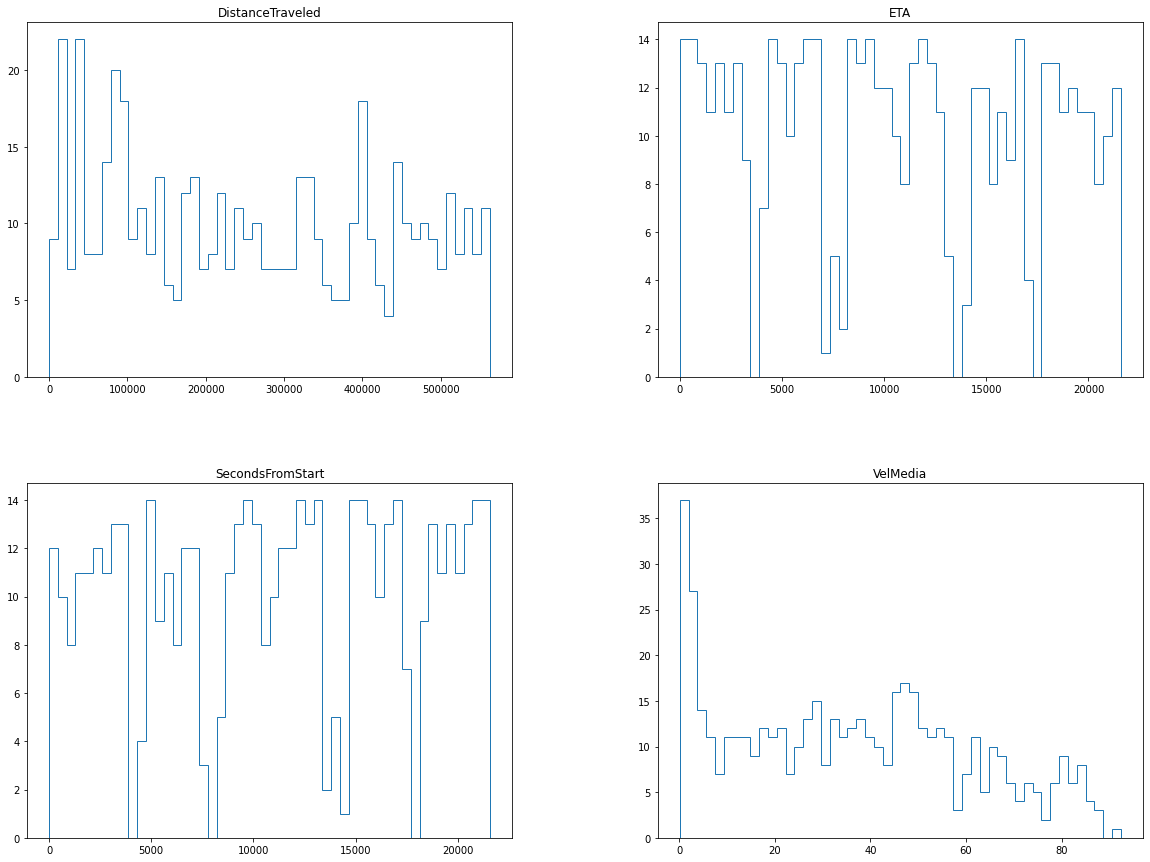

In [6]:
asd.hist(bins=50, figsize=(20, 15), histtype='step', grid=False)


Mirando el histograma de los datos no hay mucho que uno pueda resaltar en cuanto a lo que se pretende resolver.
Pero al menos podemos decir que el movil durante varios sectores del trayecto se detiene debido a la cantidad de velocidades cercanas a cero.
Ahora miremos la matriz de correlacion, simplemente vemos si existe algun sentido en nuestra eleccion.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b1cefa9a0>,
      dtype=object)

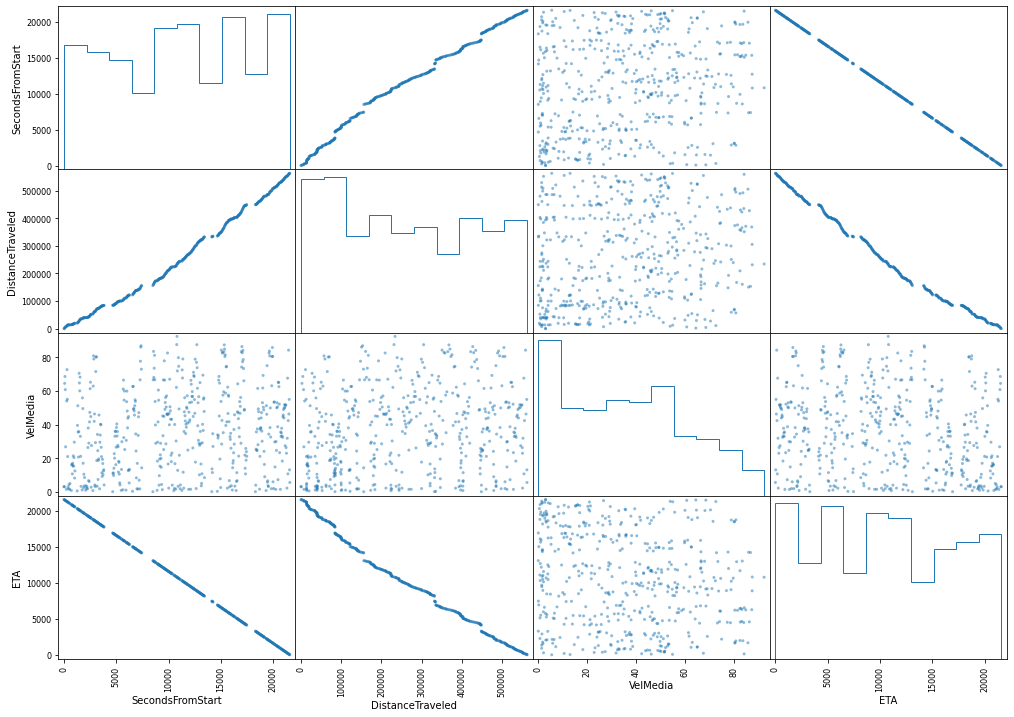

In [7]:
scatter_matrix(asd, figsize=(17, 12), hist_kwds={'histtype': 'step'})

Obviamente, las variables mas correlacionadas son
ETA vs Distaancia, Distacia vs Tiempo de viaje.
Nada para sorprenderse. aunque podemos ver que la velocidad media no esta muy relacionada con las otras tres variables. Pero por cuestiones de "causalidad" debise ser fundamental debido a que una mayor velocidad media en un mayor tiempo implica mayor distancia recorida, esto sera muy importante para nuestro problema debido que las redes neuronales LSTM son capaces de comprender estas caracteristicas ya que no solo se fijan en el ultimo punto si no comprenden un orden temporal en los datos en si.

Siguiendo con el problema, miremos como se ve el grafico de Distance VS ETA

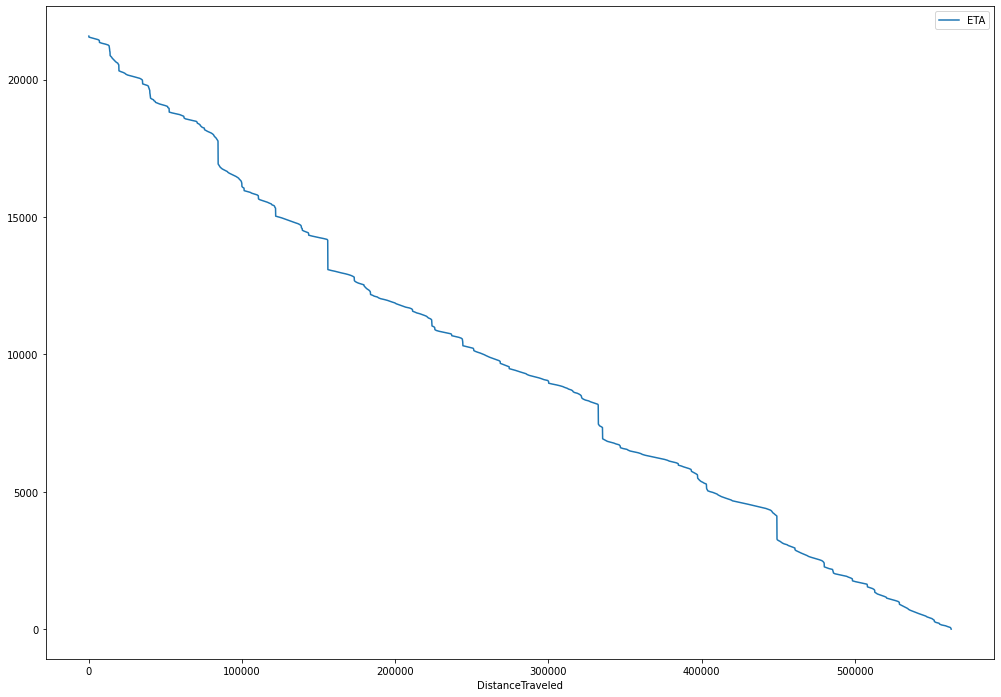

In [8]:
asd.plot(x="DistanceTraveled", y="ETA", figsize=(17, 12))

Como se puede notar, existen ciertos pratones, y quizas algun defecto en los datos el cual desconozco, esto se intuye debido a esos "semi-picos" que se repiten a cada distancia recorrida. Evidentemente esto prodria producir un error extra a nuestro entrenamiento, memorizando un error sistematico de medicion. pero se obviara, debido a que no parece ser un error que imapcte de manera global en lo que debise entenderse como un ETA real. Si lo piensa bien, el ETA real debiese ser una linea recta con pendiente negativa (suponienod que el movil solo se mueve en una direccion del trayecto).

---
# 2. preparacion del data set, creacion de la red neuronal y entrenamiento

En primero lugar seccionamos los datos 80% entrenamiento y 20% validacion. 
En segundo lugar voy a estandarizar el conjunto de datos utilizando la media y la desviación estándar (para ambos conjuntos por separado)

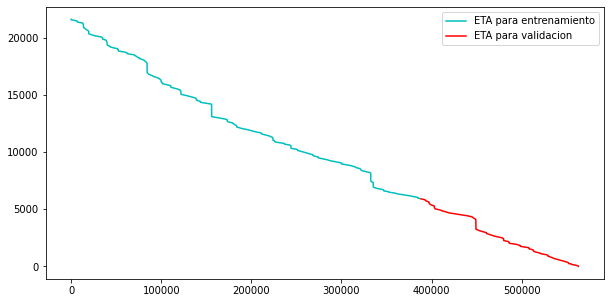

In [9]:
train, val = train_test_split(asd, test_size=0.3, shuffle=False)

train = train.values
val = val.values

plt.figure(figsize=(10, 5))
plt.plot(train[:, 1], train[:, 3], color='c', label='ETA para entrenamiento')
plt.plot(val[:, 1], val[:, 3], color='r', label='ETA para validacion')
plt.legend()
plt.show()

Una buena practica es escalar los datatos para reducir el ruido cuando se este haciendo el entrenamiento y/o inferencia. Unsando la libreria sklearn, esto es muy facil de lograr, como tambien el proceso inverso cuando queramos mostrar resultados.

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

train_scal = scaler.fit_transform(train)
val_scal = scaler.fit_transform(val)
print(train_scal[:10,:3])

[[0.00000000e+00 0.00000000e+00 3.23703873e-02]
 [2.30061350e-03 2.87418471e-04 3.23703873e-02]
 [4.21779141e-03 5.29104556e-03 6.97618053e-01]
 [6.19887526e-03 1.07891561e-02 7.41900537e-01]
 [8.17995910e-03 1.56616491e-02 6.57359044e-01]
 [1.00971370e-02 1.77394976e-02 2.89070251e-01]
 [1.46983640e-02 1.80163925e-02 1.50354616e-02]
 [1.66794479e-02 2.23464146e-02 5.84053393e-01]
 [1.86605317e-02 2.81723257e-02 7.86197169e-01]
 [2.06416155e-02 3.25841715e-02 5.95110477e-01]]


Ahora veneramos nuestros datos corriendo la ventana sobre ellos, los batches de datos seran de (60,3) y el resultado sera (1,) donde corresponde al ETA.

In [11]:
time_step = 30

X_train = []
Y_train = []

m = len(train_scal)

for i in range(time_step, m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(train_scal[i - time_step:i, :3])
    # Y: el siguiente dato
    Y_train.append(train_scal[i, 3])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_val, Y_val = [], []

m = len(val_scal)

for i in range(time_step, m):
    X_val.append(val_scal[i - time_step:i, :3])
    Y_val.append(val_scal[i, 3])
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val.shape

(122, 30, 3)

Creamos nuestro modelo y lo ploteamos para ver como se ve esquematicamente

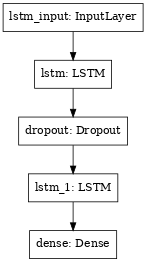

In [12]:
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(100, input_shape= (X_train.shape[1],3), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(100),
        tf.keras.layers.Dense(1)
                                ])
model.compile(optimizer='adam', loss='mse')

tf.keras.utils.plot_model(
                model, to_file='model.png', show_shapes=False, show_layer_names=True,
                rankdir='TB', expand_nested=False, dpi=56)

Comenzamos el entrenamiento y se ve claramente que los resultados van en buena direccion.

In [13]:
history = model.fit(X_train,Y_train, epochs=10,batch_size=32,
                    validation_data=(X_val, Y_val))

Epoch 1/10
11/11 [==============================] - 1s 123ms/step - loss: 0.1522 - val_loss: 0.0133
Epoch 2/10
11/11 [==============================] - 1s 57ms/step - loss: 0.0293 - val_loss: 0.0295
Epoch 3/10
11/11 [==============================] - 1s 58ms/step - loss: 0.0124 - val_loss: 0.0070
Epoch 4/10
11/11 [==============================] - 1s 58ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 5/10
11/11 [==============================] - 1s 61ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 6/10
11/11 [==============================] - 1s 58ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 7/10
11/11 [==============================] - 1s 53ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 8/10
11/11 [==============================] - 1s 53ms/step - loss: 0.0011 - val_loss: 6.8037e-04
Epoch 9/10
11/11 [==============================] - 1s 51ms/step - loss: 0.0017 - val_loss: 0.0063
Epoch 10/10
11/11 [==============================] - 1s 52ms/step - loss: 0.0013 - val_loss: 0.0014


# 3. Analisis de resultados
Miremos a ver que paso con nuestros resultados. Debido que pueden usarse multiples configuraciones para lograr otros resultados mejores o peores

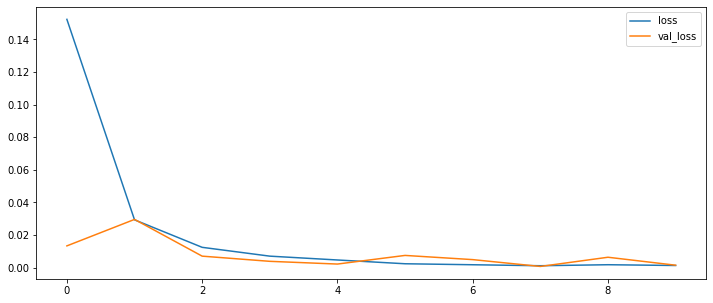

In [14]:
loss = history.history['loss']
x = range(len(loss))

plt.figure(figsize=(12,5))
for key in history.history.keys():
    plt.plot(x, history.history[key], label=key)
plt.legend()

Los resultados prometen, veamos entonces como se ve nuestro modelo en accion

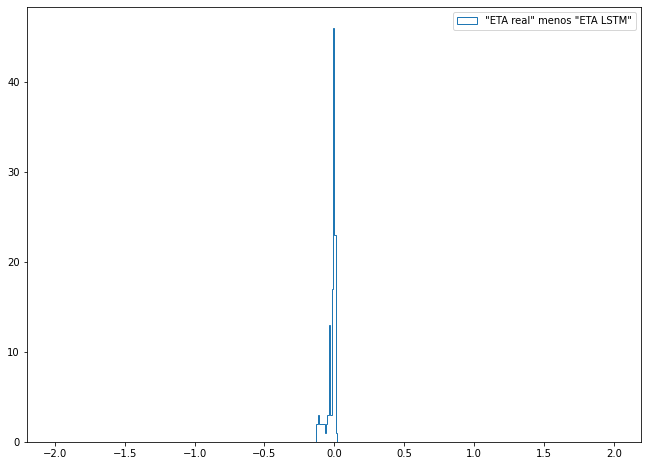

In [15]:
pred = model.predict(X_val)
pred = np.reshape(pred, -1)
ETA_real = np.reshape(Y_val, -1)
if ETA_real.shape == pred.shape:
    plt.figure(figsize=(11,8))
    plt.hist(ETA_real - pred, np.arange(-2, 2, 0.01), histtype='step', label='"ETA real" menos "ETA LSTM"')
    plt.legend()
    plt.show()

Como se muestra en la en el grafico, el error es bajisimo... aunque vems un segundo pico por algo que ya habia predicho antes, un error sistematico del cual desconozco su naturaleza.

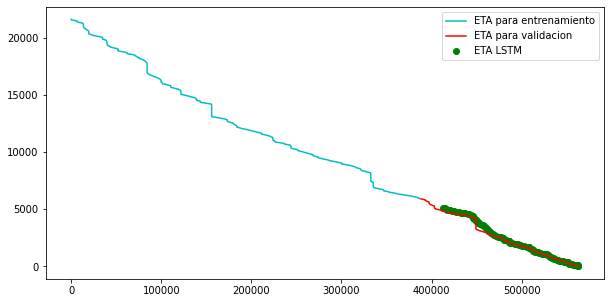

In [16]:
pred = model.predict(X_val)
max = val[:, 3].max()

plt.figure(figsize=(10, 5))
plt.plot(train[:, 1], train[:, 3], color='c', label='ETA para entrenamiento')
plt.plot(val[:, 1], val[:, 3], color='r', label='ETA para validacion')
plt.scatter(val[:, 1][30:], pred*max, color='g', label='ETA LSTM')
plt.legend()
plt.show()

# Conclusiones

Segun el analisis hecho en el capitulo 3 del presente trabajo se logro probar que el metodo de para estimar ETA basado en redes neuronales tipo LSTM es muy potente. Con unos errores de calculos muy aceptables como lo muestra el histograma (ETA Real - ETA LSTM) como tambien el grafico de arriba donde "ETA LSTM" practicamente  se corresponde con "ETA para validacion". Evidentemente este seria un resultado aplicable a algun sistema de gestion de trafico si se usara para estimar el ETA de multiples vehiculos.

Cesar Munoz A.